In [78]:
import pandas as pd  
import numpy as np  

import os
for dirname, _, filenames in os.walk('/Users/tavsiev/Desktop/projet_kaggle/projet/classification-multi-classes'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss, classification_report 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_regression
from numpy import median

/Users/tavsiev/Desktop/projet_kaggle/projet/classification-multi-classes/test.csv
/Users/tavsiev/Desktop/projet_kaggle/projet/classification-multi-classes/train.csv
/Users/tavsiev/Desktop/projet_kaggle/projet/classification-multi-classes/sample_submission.csv


In [2]:
train_df = pd.read_csv("/Users/tavsiev/Desktop/projet_kaggle/projet/classification-multi-classes/train.csv", 
                      delimiter = ",",
                      header = 0)

train_df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,1055.0,NaN,19724.0,F,NaN,NaN,NaN,N,1.3,NaN,3.64,NaN,NaN,NaN,NaN,209.0,10.5,3.0,C
1,1,3282.0,Placebo,17884.0,F,N,Y,Y,N,0.7,309.0,3.60,96.0,1142.0,71.3,106.0,240.0,12.4,4.0,C
2,2,1653.0,NaN,20600.0,F,NaN,NaN,NaN,N,2.2,NaN,3.64,NaN,NaN,NaN,NaN,139.0,9.5,2.0,C
3,3,999.0,D-penicillamine,22514.0,F,N,Y,N,N,1.0,498.0,3.35,89.0,1601.0,164.3,85.0,394.0,9.7,3.0,C
4,4,2202.0,NaN,17897.0,F,NaN,NaN,NaN,N,17.2,NaN,3.15,NaN,NaN,NaN,NaN,432.0,11.2,3.0,C


In [3]:
train_df.shape
# total de 15 000 lignes
# priorité: traitement des NA

(15000, 20)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8564 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8563 non-null   object 
 6   Hepatomegaly   8564 non-null   object 
 7   Spiders        8555 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6669 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8452 non-null   float64
 13  Alk_Phos       8558 non-null   float64
 14  SGOT           8555 non-null   float64
 15  Tryglicerides  6630 non-null   float64
 16  Platelets      14414 non-null  float64
 17  Prothrombin    14974 non-null  float64
 18  Stage 

In [5]:
train_df['Status'].value_counts()
# les classes sont déséquilibrées 
# en tenir compte 

Status
C     10049
D      4560
CL      391
Name: count, dtype: int64

Status: C si le patient est encore vivant

Status: CL si le patient est vivant mais transplanté

Status: D si le patient est mort


In [6]:
# problème au niveau de l'ID? 
# train_df['id'].value_counts().sort_values().sum()

# ID en int, on transforme en object
# train_df['id'] = train_df['id'].astype('object')

# len(train_df['id'].unique())
# train_df['id'].value_counts().sort_values()

À priori un unique ID est attribué à chaque patient.

In [7]:
# train_df.info()
# ID OK 
# AU NIVEAU DES AUTRES COLONNES?
# POUR: id, N_Days, Age, Sex, Edema, Bilirubin, Albumin, Stage, Status PAS DE NA
# DONC OK

In [8]:
train_df['Drug'].value_counts()

Drug
D-penicillamine    4568
Placebo            3996
Name: count, dtype: int64

In [9]:
# parfois on a des cases vides, ou des cases avec 'NA', 'None', 'nan' mais Python les détecte 
# pas toujours de la même façon
# je fais la somme des NA et des colonnes non nulles pour m'en assurer
print(train_df['Ascites'].value_counts())
print(train_df['Ascites'].isna().sum())
print(train_df['Ascites'].notnull().sum())
print(train_df['Ascites'].isna().sum() + train_df['Ascites'].notnull().sum())

# boucle en bas pour toutes les variables

Ascites
N                  8178
Y                   383
S                     1
D-penicillamine       1
Name: count, dtype: int64
6437
8563
15000


In [10]:
# for col in train_df.columns:
#    print(f"--- Analyse de la colonne: {col} ---")
#    print("Valeurs uniques et leurs occurrences:")
#    print(train_df[col].value_counts(dropna=False))  # Inclut NaN dans le comptage
#    print(f"Valeurs manquantes (NaN): {train_df[col].isna().sum()}")
#    print(f"Valeurs non manquantes: {train_df[col].notnull().sum()}")
#    total = train_df[col].isna().sum() + train_df[col].notnull().sum()
#    print(f"Total (manquantes + non manquantes): {total}")
#    print()

# OK, VERIFIÉ

Regarder le taux de NA pour chaque variable.

Il est possible que ce soit les mêmes individus pour lesquels on a des NA, donc un groupe qui n'aurait pas suivi le protocole.

Voir la variable 'Drug' où y a eu un placebo et un médicament testé mais cela représente que 8500 personnes. Or, environ 6500 n'ont rien eu donc soit c'est placebo, soit ils n'ont pas participé dutout à l'expérience.

In [11]:
# les valeurs que prennent les colonnes de type 'object'
for col in train_df.select_dtypes(include=['object']).columns:
    unique_values = ', '.join(map(str, train_df[col].unique()))
    print(f"Colonne '{col}': {unique_values}")


# N --> No 
# Y --> Yes
# F --> Female
# M --> Male

# pour 'Drug': Placebo et D-penicillamine
# mais pour 'Ascites', la valeur D-penicillamine est une erreur 
# mais pour 'Ascites', la valeur de S est une erreur 
# 'Ascites' prend que N (oui) et Y (non) 
# dans Edema, le S apparaît 800 fois donc OK 

Colonne 'Drug': nan, Placebo, D-penicillamine
Colonne 'Sex': F, M
Colonne 'Ascites': nan, N, Y, S, D-penicillamine
Colonne 'Hepatomegaly': nan, Y, N, 119.35
Colonne 'Spiders': nan, Y, N
Colonne 'Edema': N, Y, S
Colonne 'Status': C, D, CL


In [12]:
train_df = train_df[~train_df['Ascites'].isin(['D-penicillamine', 'S'])]
train_df = train_df[train_df['Hepatomegaly'] != '119.35']

train_df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,1055.0,NaN,19724.0,F,NaN,NaN,NaN,N,1.3,NaN,3.64,NaN,NaN,NaN,NaN,209.0,10.5,3.0,C
1,1,3282.0,Placebo,17884.0,F,N,Y,Y,N,0.7,309.0,3.60,96.0,1142.0,71.3,106.0,240.0,12.4,4.0,C
2,2,1653.0,NaN,20600.0,F,NaN,NaN,NaN,N,2.2,NaN,3.64,NaN,NaN,NaN,NaN,139.0,9.5,2.0,C
3,3,999.0,D-penicillamine,22514.0,F,N,Y,N,N,1.0,498.0,3.35,89.0,1601.0,164.3,85.0,394.0,9.7,3.0,C
4,4,2202.0,NaN,17897.0,F,NaN,NaN,NaN,N,17.2,NaN,3.15,NaN,NaN,NaN,NaN,432.0,11.2,3.0,C


In [13]:
for col in train_df.select_dtypes(include=['object']).columns:
    unique_values = ', '.join(map(str, train_df[col].unique()))
    print(f"Colonne '{col}': {unique_values}")

Colonne 'Drug': nan, Placebo, D-penicillamine
Colonne 'Sex': F, M
Colonne 'Ascites': nan, N, Y
Colonne 'Hepatomegaly': nan, Y, N
Colonne 'Spiders': nan, Y, N
Colonne 'Edema': N, Y, S
Colonne 'Status': C, D, CL


In [14]:
# format des colonnes + âge (en Jours vers Années)
train_df['Age'] = (train_df['Age'] / 365.25).round()

cat_col = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

# One-Hot Encodaging pour les colonnes catégorielles
train_df_encoded = pd.get_dummies(train_df, columns=cat_col, drop_first=True)

In [15]:
train_df_encoded.shape

(14997, 21)

### **Test rapide :**

In [16]:
train_df_clean = train_df_encoded.dropna()
train_df_clean.shape

(6336, 21)

In [17]:
train_df_clean['Status'] = train_df_clean['Status'].map({'C': 0, 'CL': 1, 'D': 2})

/var/folders/zc/__4fgnp121vflx6jgwz_rg240000gn/T/ipykernel_1221/3080838254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_clean['Status'] = train_df_clean['Status'].map({'C': 0, 'CL': 1, 'D': 2})


In [18]:
X = train_df_clean.drop(['id', 'Status'], axis=1) 
y = train_df_clean['Status']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)

model.fit(X_train, y_train)

/Users/tavsiev/Desktop/projet_kaggle/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


/Users/tavsiev/Desktop/projet_kaggle/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=10000, multi_class='multinomial')

In [20]:
y_pred_proba = model.predict_proba(X_test)

logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss: {logloss}")

Log Loss: 0.43158959182300993


In [21]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['C', 'CL', 'D']))

              precision    recall  f1-score   support

           C       0.87      0.94      0.90       873
          CL       1.00      0.04      0.08        46
           D       0.78      0.72      0.75       349

    accuracy                           0.85      1268
   macro avg       0.88      0.57      0.58      1268
weighted avg       0.85      0.85      0.83      1268



In [37]:
train = pd.read_csv("/Users/tavsiev/Desktop/projet_kaggle/projet/classification-multi-classes/train.csv", 
                      delimiter = ",",
                      header = 0)

test = pd.read_csv("/Users/tavsiev/Desktop/projet_kaggle/projet/classification-multi-classes/test.csv", 
                      delimiter = ",",
                      header = 0)

train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,1055.0,NaN,19724.0,F,NaN,NaN,NaN,N,1.3,NaN,3.64,NaN,NaN,NaN,NaN,209.0,10.5,3.0,C
1,1,3282.0,Placebo,17884.0,F,N,Y,Y,N,0.7,309.0,3.60,96.0,1142.0,71.3,106.0,240.0,12.4,4.0,C
2,2,1653.0,NaN,20600.0,F,NaN,NaN,NaN,N,2.2,NaN,3.64,NaN,NaN,NaN,NaN,139.0,9.5,2.0,C
3,3,999.0,D-penicillamine,22514.0,F,N,Y,N,N,1.0,498.0,3.35,89.0,1601.0,164.3,85.0,394.0,9.7,3.0,C
4,4,2202.0,NaN,17897.0,F,NaN,NaN,NaN,N,17.2,NaN,3.15,NaN,NaN,NaN,NaN,432.0,11.2,3.0,C


In [32]:
test.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,611.0,D-penicillamine,21828.0,F,N,Y,N,N,0.8,198.0,3.90,39.0,855.0,66.65,56.0,295.0,10.5,4.0
1,15001,2103.0,NaN,21915.0,F,NaN,NaN,NaN,N,0.6,NaN,3.81,NaN,NaN,NaN,NaN,269.0,10.5,3.0
2,15002,130.0,NaN,23011.0,F,NaN,NaN,NaN,N,0.7,NaN,3.94,NaN,NaN,NaN,NaN,425.0,10.8,4.0
3,15003,1635.0,NaN,20089.0,F,NaN,NaN,NaN,N,0.6,NaN,3.50,NaN,NaN,NaN,NaN,248.0,10.3,2.0
4,15004,3336.0,D-penicillamine,15031.0,F,N,N,N,N,0.5,NaN,4.52,29.0,766.0,74.40,NaN,474.0,10.1,2.0


In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14997 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         14997 non-null  float64
 1   Drug           8561 non-null   object 
 2   Age            14997 non-null  float64
 3   Sex            14997 non-null  object 
 4   Ascites        8560 non-null   object 
 5   Hepatomegaly   8561 non-null   object 
 6   Spiders        8552 non-null   object 
 7   Edema          14997 non-null  object 
 8   Bilirubin      14997 non-null  float64
 9   Cholesterol    6667 non-null   float64
 10  Albumin        14997 non-null  float64
 11  Copper         8449 non-null   float64
 12  Alk_Phos       8555 non-null   float64
 13  SGOT           8552 non-null   float64
 14  Tryglicerides  6628 non-null   float64
 15  Platelets      14411 non-null  float64
 16  Prothrombin    14971 non-null  float64
 17  Stage          14997 non-null  float64
 18  Status     

In [81]:
train.shape, test.shape

((14997, 19), (10000, 18))

In [82]:
# drop the id column since it does not make any changes to the result
#train = train.drop('id', axis = 1)
#test = test.drop('id', axis = 1)

In [83]:
# check if there have NAs
train.isna().sum().any(),  test.isna().sum().any()

(np.True_, np.True_)

In [84]:
# check for duplicates
total = pd.concat([train.drop('Status', axis=1), test], axis = 0)
total.duplicated().sum()

np.int64(15)

In [108]:
total.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 24997, dtype: bool

In [86]:
total.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1055.0,NaN,19724.0,F,NaN,NaN,NaN,N,1.3,NaN,3.64,NaN,NaN,NaN,NaN,209.0,10.5,3.0
1,3282.0,Placebo,17884.0,F,N,Y,Y,N,0.7,309.0,3.60,96.0,1142.0,71.3,106.0,240.0,12.4,4.0
2,1653.0,NaN,20600.0,F,NaN,NaN,NaN,N,2.2,NaN,3.64,NaN,NaN,NaN,NaN,139.0,9.5,2.0
3,999.0,D-penicillamine,22514.0,F,N,Y,N,N,1.0,498.0,3.35,89.0,1601.0,164.3,85.0,394.0,9.7,3.0
4,2202.0,NaN,17897.0,F,NaN,NaN,NaN,N,17.2,NaN,3.15,NaN,NaN,NaN,NaN,432.0,11.2,3.0


In [87]:
total.shape

(24997, 18)

In [88]:
# check for numbers of unique values in each columns
train[train.columns].nunique().sort_values(ascending=True)

Drug               2
Sex                2
Hepatomegaly       2
Ascites            2
Spiders            2
Edema              3
Status             3
Stage              4
Prothrombin       54
Bilirubin        118
Tryglicerides    153
Albumin          165
Copper           170
SGOT             201
Cholesterol      210
Platelets        267
Age              375
Alk_Phos         387
N_Days           543
dtype: int64

In [89]:
# Hepatomegaly has three value, let's take a look at it
# valeur numérique est une erreur donc supprimer
train.Hepatomegaly.value_counts()

Hepatomegaly
N    4563
Y    3998
Name: count, dtype: int64

In [90]:
# Edema has three value, let's take a look at it
train.Edema.value_counts()

Edema
N    13822
S      810
Y      365
Name: count, dtype: int64

After investigation, those values are
- N: No
- Y: Yes
- S: Slight

In [91]:
# take a look at the Drug column
train.Drug.value_counts()

Drug
D-penicillamine    4567
Placebo            3994
Name: count, dtype: int64

In [92]:
# check for target data
train.Status.value_counts()

Status
C     10048
D      4558
CL      391
Name: count, dtype: int64

In [93]:
# supprimer S et D-penicillamine
train.Ascites.value_counts()

Ascites
N    8178
Y     382
Name: count, dtype: int64

In [94]:
# Valeur manquante
train.isna().sum()/len(train)*100

N_Days            0.000000
Drug             42.915250
Age               0.000000
Sex               0.000000
Ascites          42.921918
Hepatomegaly     42.915250
Spiders          42.975262
Edema             0.000000
Bilirubin         0.000000
Cholesterol      55.544442
Albumin           0.000000
Copper           43.662066
Alk_Phos         42.955258
SGOT             42.975262
Tryglicerides    55.804494
Platelets         3.907448
Prothrombin       0.173368
Stage             0.000000
Status            0.000000
dtype: float64

In [95]:
# get numeric data
num_train = train.select_dtypes(include = ['int', 'float'])
num_train.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1055.0,19724.0,1.3,NaN,3.64,NaN,NaN,NaN,NaN,209.0,10.5,3.0
1,3282.0,17884.0,0.7,309.0,3.60,96.0,1142.0,71.3,106.0,240.0,12.4,4.0
2,1653.0,20600.0,2.2,NaN,3.64,NaN,NaN,NaN,NaN,139.0,9.5,2.0
3,999.0,22514.0,1.0,498.0,3.35,89.0,1601.0,164.3,85.0,394.0,9.7,3.0
4,2202.0,17897.0,17.2,NaN,3.15,NaN,NaN,NaN,NaN,432.0,11.2,3.0


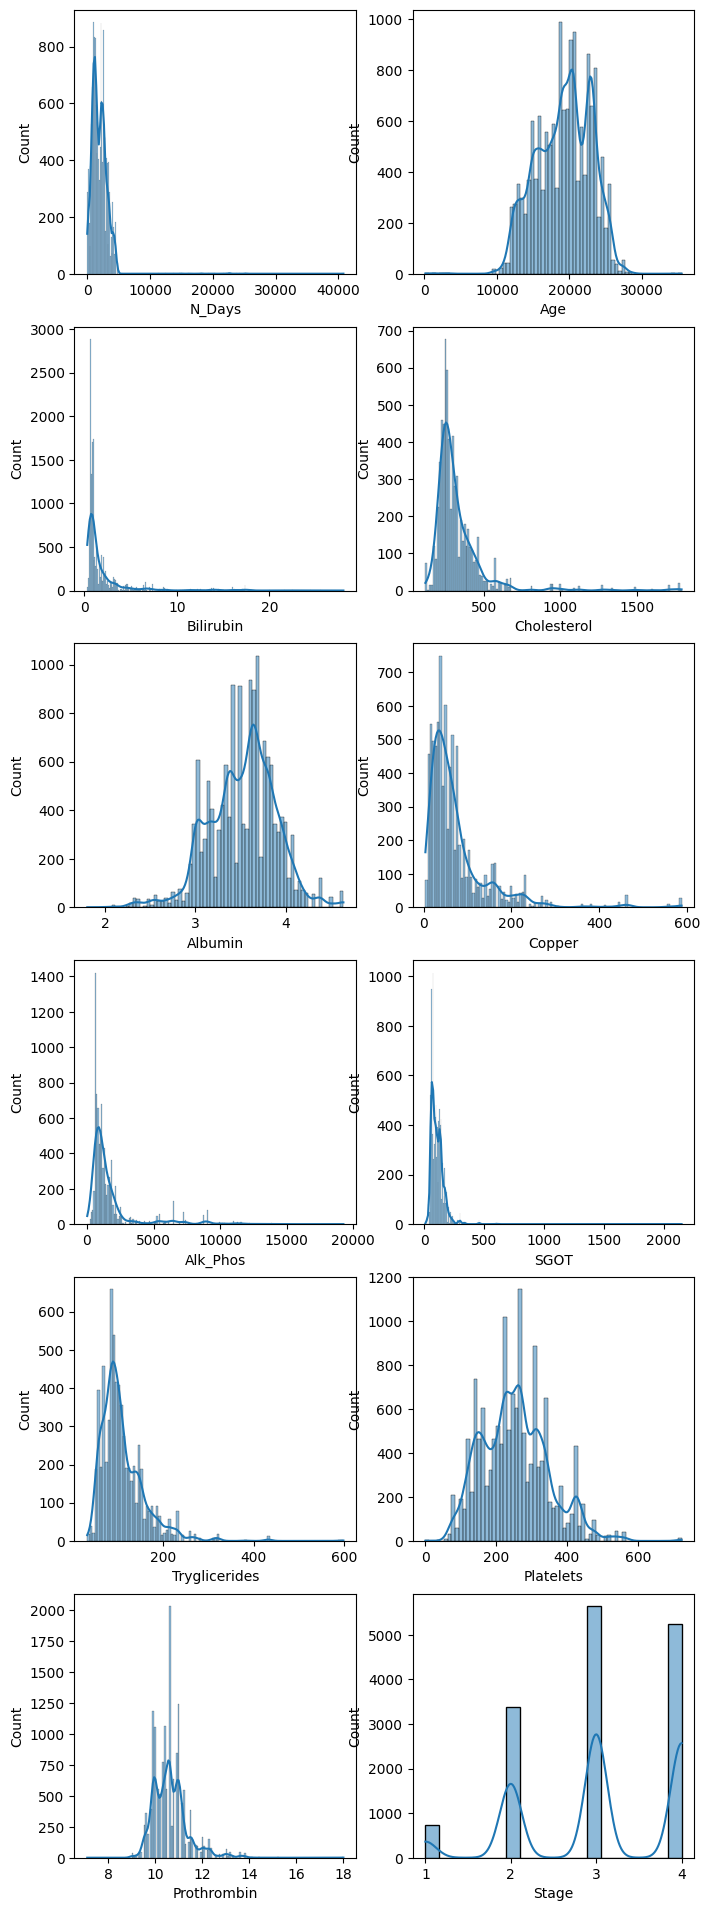

In [96]:
# plot the numerical data
rows = (len(num_train.columns)+1)//2
_, axes = plt.subplots(rows, 2, figsize = (8, rows*4))
for i, col in enumerate(num_train.columns):
    hor = i%2
    ver = i//2
    sns.histplot(data = num_train[col], kde = True, ax = axes[ver, hor])

In [97]:
# extract the categorical features
cat_train = train.select_dtypes(include = ['object']).astype('category')
cat_train.head()

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
0,NaN,F,NaN,NaN,NaN,N,C
1,Placebo,F,N,Y,Y,N,C
2,NaN,F,NaN,NaN,NaN,N,C
3,D-penicillamine,F,N,Y,N,N,C
4,NaN,F,NaN,NaN,NaN,N,C


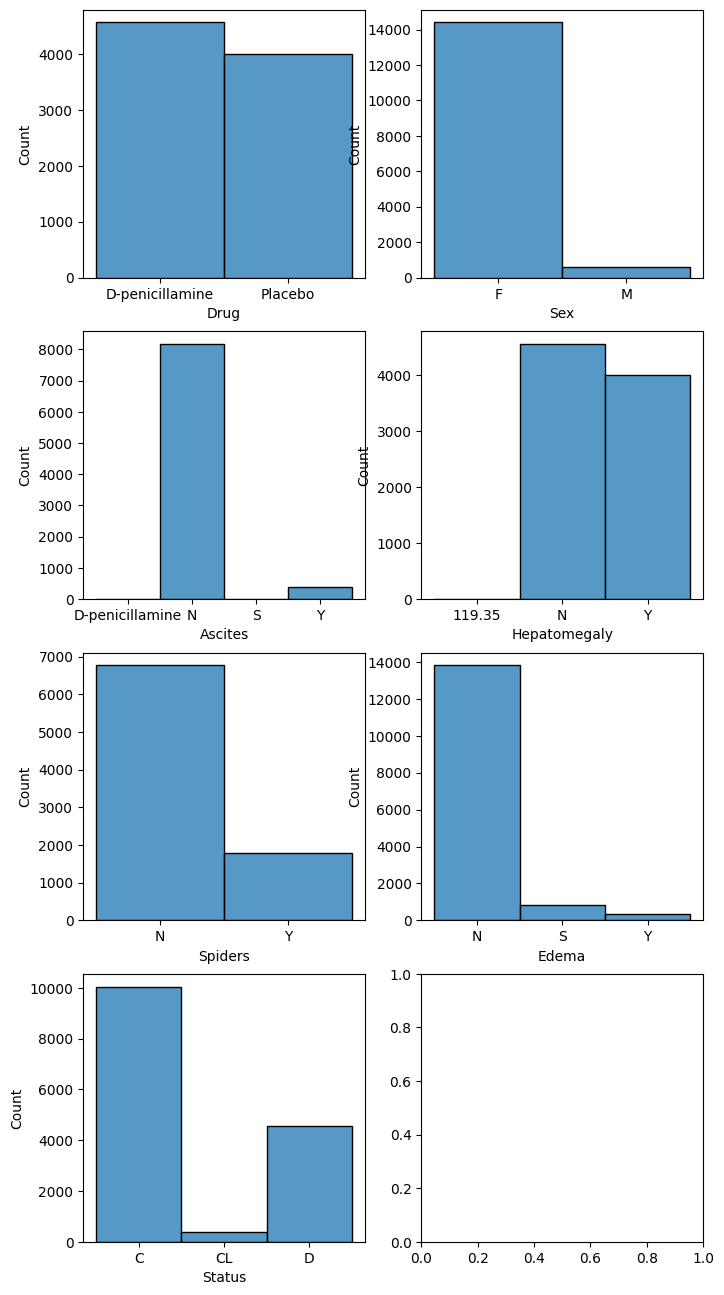

In [50]:
# plot the categorical data
rows = (len(cat_train.columns)+1)//2
_, axes = plt.subplots(rows, 2, figsize = (8, rows*4))
for i, col in enumerate(cat_train.columns):
    hor = i%2
    ver = i//2
    sns.histplot(data = cat_train[col], ax = axes[ver, hor])

In [61]:
train = train[~train['Ascites'].isin(['D-penicillamine', 'S'])]
train = train[train['Hepatomegaly'] != '119.35']

# extract the categorical features
cat_train = train.select_dtypes(include = ['object']).astype('category')
cat_train.head()

num_train = train.select_dtypes(include = ['int', 'float'])
num_train.head()

train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,1055.0,NaN,19724.0,F,NaN,NaN,NaN,N,1.3,NaN,3.64,NaN,NaN,NaN,NaN,209.0,10.5,3.0,C
1,3282.0,Placebo,17884.0,F,N,Y,Y,N,0.7,309.0,3.60,96.0,1142.0,71.3,106.0,240.0,12.4,4.0,C
2,1653.0,NaN,20600.0,F,NaN,NaN,NaN,N,2.2,NaN,3.64,NaN,NaN,NaN,NaN,139.0,9.5,2.0,C
3,999.0,D-penicillamine,22514.0,F,N,Y,N,N,1.0,498.0,3.35,89.0,1601.0,164.3,85.0,394.0,9.7,3.0,C
4,2202.0,NaN,17897.0,F,NaN,NaN,NaN,N,17.2,NaN,3.15,NaN,NaN,NaN,NaN,432.0,11.2,3.0,C


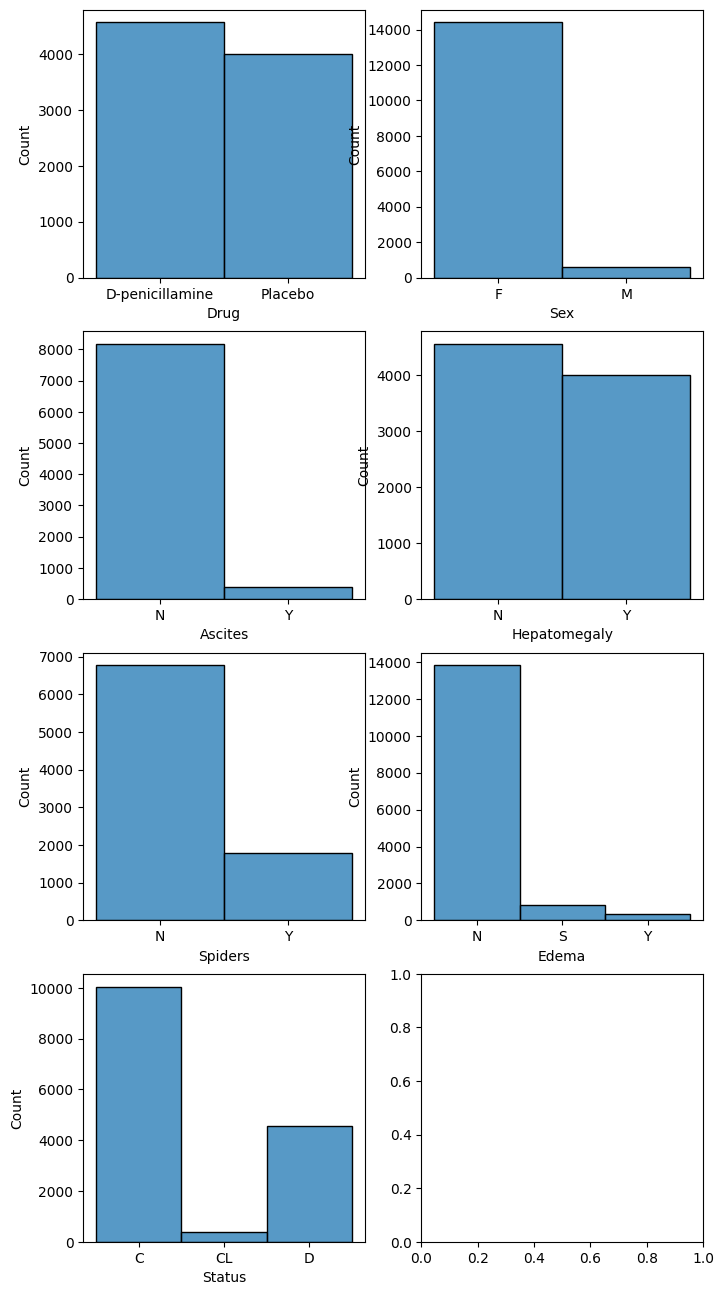

In [62]:
# plot the categorical data after correction
rows = (len(cat_train.columns)+1)//2
_, axes = plt.subplots(rows, 2, figsize = (8, rows*4))
for i, col in enumerate(cat_train.columns):
    hor = i%2
    ver = i//2
    sns.histplot(data = cat_train[col], ax = axes[ver, hor])

### Feature Engineering

In [63]:
train_eng = train.copy()
test_eng = test.copy()

In [102]:
# feature engineering for categorical features
def col_transform (df:pd.DataFrame):
    df_trans  = df.copy()
    #apply manual transformation for bionomial features
    for col in df.select_dtypes(include=['object']):
        if df_trans[col].nunique() <3 and (col != 'Sex'):
            if col == 'Drug':
                df_trans[col] = df_trans[col].map({'D-penicillamine': True, 'Placebo': False}).astype('bool')
            else:
                df_trans[col] = df_trans[col].map({'Y': True, 'N': False}).astype('bool')
        else:
            #apply one hot encoding for others
            df_trans = pd.concat([df_trans, pd.get_dummies(df_trans[col], prefix = col)], axis = 1)
            df_trans = df_trans.drop(col, axis = 1)
    return df_trans

In [103]:
train_eng1 = col_transform(train_eng)
train_eng1

,N_Days,Drug,Age,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,...,Prothrombin,Stage,Sex_F,Sex_M,Edema_N,Edema_S,Edema_Y,Status_C,Status_CL,Status_D
0,1055.0,True,19724.0,True,True,True,1.3,NaN,3.64,NaN,...,10.5,3.0,True,False,True,False,False,True,False,False
1,3282.0,False,17884.0,False,True,True,0.7,309.0,3.60,96.0,...,12.4,4.0,True,False,True,False,False,True,False,False
2,1653.0,True,20600.0,True,True,True,2.2,NaN,3.64,NaN,...,9.5,2.0,True,False,True,False,False,True,False,False
3,999.0,True,22514.0,False,True,False,1.0,498.0,3.35,89.0,...,9.7,3.0,True,False,True,False,False,True,False,False
4,2202.0,True,17897.0,True,True,True,17.2,NaN,3.15,NaN,...,11.2,3.0,True,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1831.0,False,20284.0,False,False,True,1.0,322.0,3.68,52.0,...,9.9,3.0,True,False,True,False,False,True,False,False
14996,611.0,True,24585.0,True,True,False,1.8,NaN,3.14,18.0,...,11.0,4.0,True,False,False,False,True,False,False,True
14997,3098.0,False,20440.0,False,True,True,0.9,348.0,3.93,464.0,...,10.6,4.0,True,False,True,False,False,True,False,False
14998,4453.0,True,17897.0,True,True,True,2.1,NaN,3.63,NaN,...,11.0,4.0,True,False,True,False,False,False,False,True


In [68]:
# apply PowerTransformer for a normalized like distribution
from sklearn.preprocessing import PowerTransformer
num_train3 = num_train.copy()

transformer = PowerTransformer(method = 'yeo-johnson')

num_train3 = transformer.fit_transform(num_train3)

num_train3 = pd.DataFrame(num_train3, columns = num_train.columns)
num_train3

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,-0.689051,0.089357,0.394455,NaN,0.276424,NaN,NaN,NaN,NaN,-0.401480,-0.039424,-0.130373
1,1.092639,-0.410079,-0.705321,0.220571,0.165064,0.748544,0.035493,-0.679372,0.173426,-0.054867,2.019662,1.181181
2,-0.087901,0.334243,1.095585,NaN,0.276424,NaN,NaN,NaN,NaN,-1.291590,-1.997295,-1.183792
3,-0.754316,0.884572,-0.044225,1.395643,-0.509664,0.657765,0.552975,1.207893,-0.414701,1.409860,-1.531866,-0.130373
4,0.362898,-0.406624,1.972175,NaN,-1.023017,NaN,NaN,NaN,NaN,1.725220,0.905020,-0.130373
...,...,...,...,...,...,...,...,...,...,...,...,...
14992,0.066393,0.245389,-0.044225,0.341202,0.388722,-0.002201,0.190016,-1.074640,1.763817,-0.186288,-1.107372,-0.130373
14993,-1.277112,1.502651,0.858612,NaN,-1.048067,-1.376207,-0.231347,0.053456,NaN,-1.479472,0.662493,1.181181
14994,0.979072,0.289181,-0.233401,0.557687,1.111829,2.511126,-0.311205,0.519347,0.950897,0.768475,0.113021,1.181181
14995,1.743483,-0.406624,1.044043,NaN,0.248496,NaN,NaN,NaN,NaN,-0.131129,0.662493,1.181181


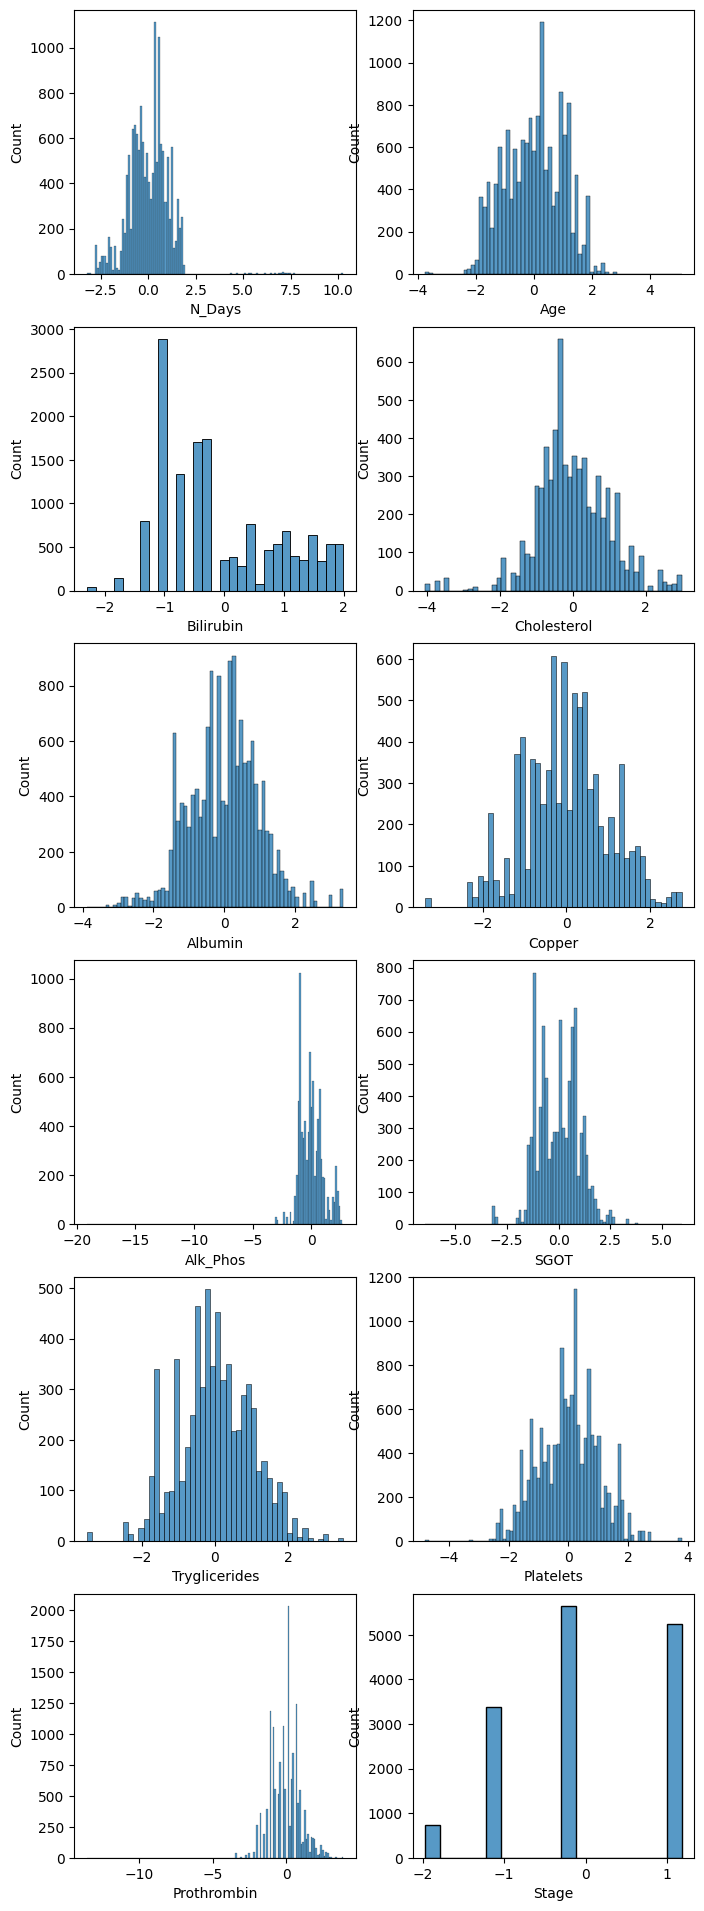

In [69]:
rows = (len(num_train3.columns)+1)//2
_, axes = plt.subplots(rows, 2, figsize = (8, rows*4))
for i, col in enumerate(num_train3.columns):
    hor = i%2
    ver = i//2
    sns.histplot(data = num_train3[col], ax = axes[ver, hor])

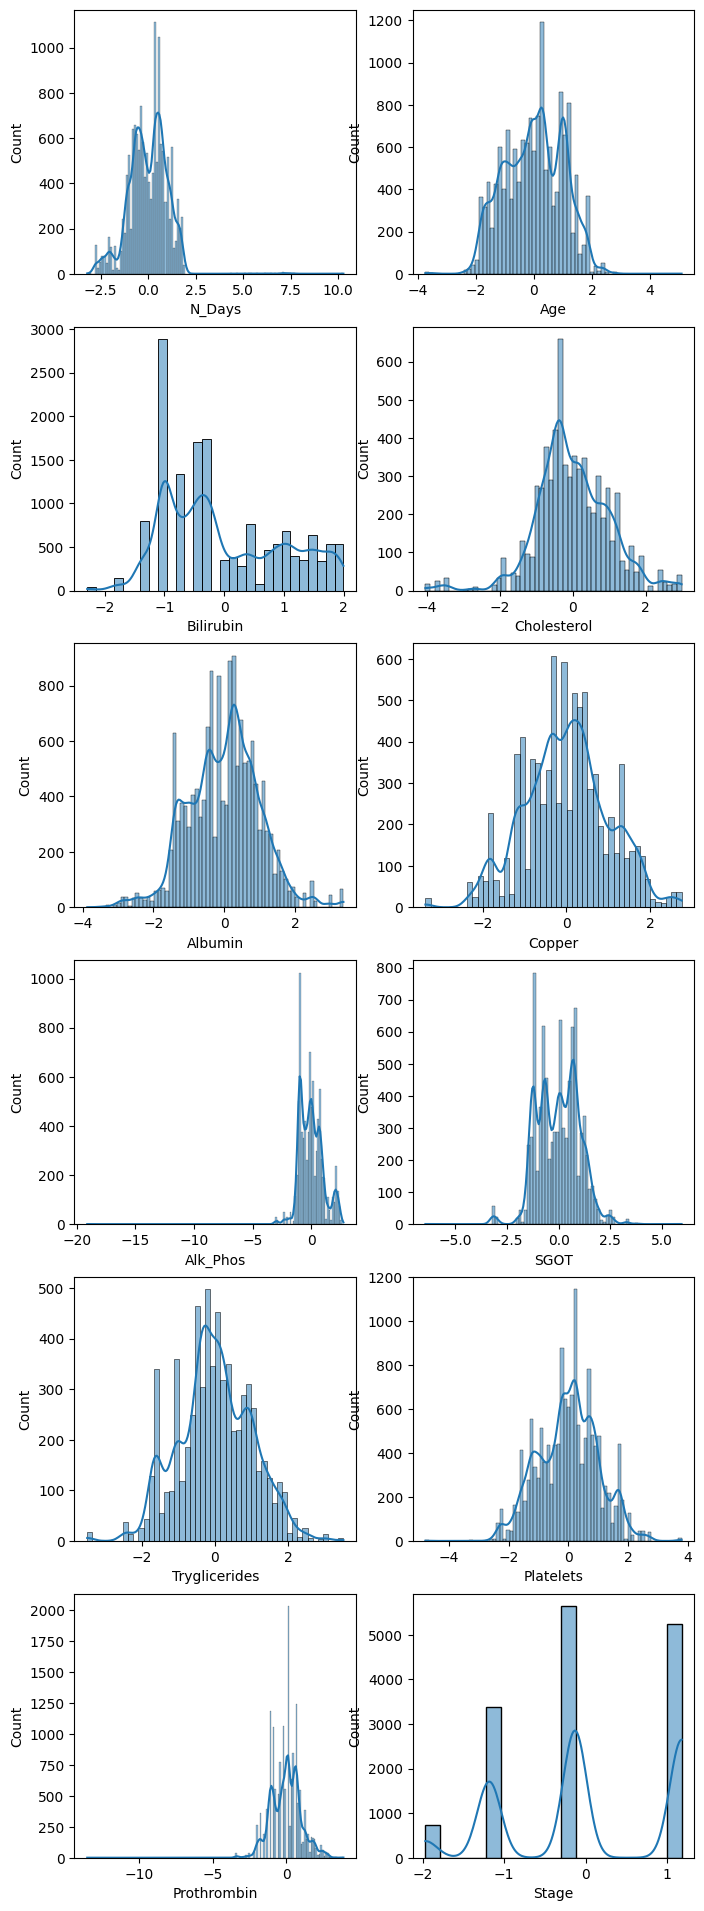

In [70]:
rows = (len(num_train3.columns)+1)//2
_, axes = plt.subplots(rows, 2, figsize = (8, rows*4))
for i, col in enumerate(num_train3.columns):
    hor = i%2
    ver = i//2
    sns.histplot(data = num_train3[col], kde = True, ax = axes[ver, hor])

In [72]:
# checking for dupliactes columns or rows
train[train.duplicated()]
# check for duplicate rows 
duplicate_rows = train[train.duplicated()]

# display the duplicate rows, if any
if not duplicate_rows.empty:
    print("Duplicate Rows:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

Duplicate Rows:
       N_Days Drug      Age Sex Ascites Hepatomegaly Spiders Edema  Bilirubin  \
7411    691.0  NaN  21185.0   F     NaN          NaN     NaN     N        0.8   
10757  2537.0  NaN  23376.0   F     NaN          NaN     NaN     N        0.6   
11234   943.0  NaN  18993.0   F     NaN          NaN     NaN     N        0.9   

       Cholesterol  Albumin  Copper  Alk_Phos  SGOT  Tryglicerides  Platelets  \
7411           NaN     3.75     NaN       NaN   NaN            NaN      269.0   
10757          NaN     4.01     NaN       NaN   NaN            NaN      314.0   
11234          NaN     3.01     NaN       NaN   NaN            NaN      256.0   

       Prothrombin  Stage Status  
7411          10.4    2.0      C  
10757         10.4    3.0      C  
11234         10.6    3.0      C  


In [ ]:
num_train3.shape, cat_train.shape

In [75]:
num_train3.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,14997.0,4.121972e-17,1.000033,-3.212299,-0.646990,0.027357,0.675385,10.278103
Age,14997.0,-4.832657e-17,1.000033,-3.750842,-0.804146,0.039597,0.842165,5.097755
Bilirubin,14997.0,-5.780237e-17,1.000033,-2.291234,-1.002941,-0.233401,0.858612,1.998144
Cholesterol,6667.0,-2.829808e-14,1.000075,-4.032539,-0.585205,-0.085028,0.647952,2.983861
Albumin,14997.0,4.065117e-16,1.000033,-3.871124,-0.666139,0.109736,0.644822,3.364811
Copper,8449.0,-2.775229e-16,1.000059,-3.370411,-0.661757,-0.002201,0.616470,2.755543
Alk_Phos,8555.0,-3.222567e-15,1.000058,-19.098917,-0.798333,-0.069849,0.629621,2.748776
SGOT,8552.0,3.614197e-16,1.000058,-6.426702,-0.689377,0.053456,0.752591,5.934785
Tryglicerides,6628.0,-5.951117e-16,1.000075,-3.490448,-0.584079,-0.003846,0.733228,3.507968
Platelets,14411.0,-5.719447e-17,1.000035,-4.797031,-0.712076,0.062812,0.674052,3.796974


In [104]:
train_eng1.describe(exclude='number').T

,count,unique,top,freq
Drug,14997,2,True,11003
Ascites,14997,2,False,8178
Hepatomegaly,14997,2,True,10434
Spiders,14997,2,True,8225
Sex_F,14997,2,True,14400
Sex_M,14997,2,False,14400
Edema_N,14997,2,True,13822
Edema_S,14997,2,False,14187
Edema_Y,14997,2,False,14632
Status_C,14997,2,True,10048


In [99]:
# missing values filled using mode values
cat_train['Drug'].fillna('D-penicillamine', inplace=True)
cat_train['Ascites'].fillna('N', inplace=True)
cat_train['Hepatomegaly'].fillna('N', inplace=True)
cat_train['Spiders'].fillna('N', inplace=True)

# missing values filled using mediuan values
from numpy import median

num_train3['Cholesterol'].fillna(median(num_train3['Cholesterol'].dropna()), inplace=True)
num_train3['Copper'].fillna(median(num_train3['Copper'].dropna()), inplace=True)
num_train3['Alk_Phos'].fillna(median(num_train3['Alk_Phos'].dropna()), inplace=True)
num_train3['SGOT'].fillna(median(num_train3['SGOT'].dropna()), inplace=True)
num_train3['Tryglicerides'].fillna(median(num_train3['Tryglicerides'].dropna()), inplace=True)
num_train3['Platelets'].fillna(median(num_train3['Platelets'].dropna()), inplace=True)
num_train3['Prothrombin'].fillna(median(num_train3['Prothrombin'].dropna()), inplace=True)

/var/folders/zc/__4fgnp121vflx6jgwz_rg240000gn/T/ipykernel_1221/3769848392.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cat_train['Drug'].fillna('D-penicillamine', inplace=True)
/var/folders/zc/__4fgnp121vflx6jgwz_rg240000gn/T/ipykernel_1221/3769848392.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [100]:
cat_train.describe(exclude='number').T

,count,unique,top,freq
Drug,14997,2,D-penicillamine,11003
Sex,14997,2,F,14400
Ascites,14997,2,N,14615
Hepatomegaly,14997,2,N,10999
Spiders,14997,2,N,13217
Edema,14997,3,N,13822
Status,14997,3,C,10048


In [101]:
num_train3.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,14997.0,4.121972e-17,1.000033,-3.212299,-0.646990,0.027357,0.675385,10.278103
Age,14997.0,-4.832657e-17,1.000033,-3.750842,-0.804146,0.039597,0.842165,5.097755
Bilirubin,14997.0,-5.780237e-17,1.000033,-2.291234,-1.002941,-0.233401,0.858612,1.998144
Cholesterol,14997.0,-4.722860e-02,0.668110,-4.032539,-0.085028,-0.085028,-0.085028,2.983861
Albumin,14997.0,4.065117e-16,1.000033,-3.871124,-0.666139,0.109736,0.644822,3.364811
Copper,14997.0,-9.610167e-04,0.750612,-3.370411,-0.102775,-0.002201,0.134080,2.755543
Alk_Phos,14997.0,-3.000372e-02,0.756096,-19.098917,-0.218820,-0.069849,0.035493,2.748776
SGOT,14997.0,2.297306e-02,0.755636,-6.426702,-0.136661,0.053456,0.207747,5.934785
Tryglicerides,14997.0,-2.146085e-03,0.664822,-3.490448,-0.003846,-0.003846,-0.003846,3.507968
Platelets,14997.0,2.454335e-03,0.980376,-4.797031,-0.626445,0.062812,0.664529,3.796974


In [105]:
train_engineered = pd.concat([num_train3, train_eng1.drop(num_train3.columns, axis = 1)], axis = 1)
train_engineered.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Hepatomegaly,Spiders,Sex_F,Sex_M,Edema_N,Edema_S,Edema_Y,Status_C,Status_CL,Status_D
0,-0.689051,0.089357,0.394455,-0.085028,0.276424,-0.002201,-0.069849,0.053456,-0.003846,-0.401480,...,True,True,True,False,True,False,False,True,False,False
1,1.092639,-0.410079,-0.705321,0.220571,0.165064,0.748544,0.035493,-0.679372,0.173426,-0.054867,...,True,True,True,False,True,False,False,True,False,False
2,-0.087901,0.334243,1.095585,-0.085028,0.276424,-0.002201,-0.069849,0.053456,-0.003846,-1.291590,...,True,True,True,False,True,False,False,True,False,False
3,-0.754316,0.884572,-0.044225,1.395643,-0.509664,0.657765,0.552975,1.207893,-0.414701,1.409860,...,True,False,True,False,True,False,False,True,False,False
4,0.362898,-0.406624,1.972175,-0.085028,-1.023017,-0.002201,-0.069849,0.053456,-0.003846,1.725220,...,True,True,True,False,True,False,False,True,False,False


In [106]:
train_engineered.shape

(15000, 24)

In [ ]:
train_df_clean['Status'] = train_df_clean['Status'].map({'C': 0, 'CL': 1, 'D': 2})

In [ ]:
X = train_df_clean.drop(['id', 'Status'], axis=1) 
y = train_df_clean['Status']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)